## Installing Libraries and Dependencies

In [4]:
import matplotlib.pyplot as plt 
import numpy as np              
import pandas as pd           

In [ ]:
batch_size = 16          # Number of training examples utilized in one #iteration
img_width = 500
img_height = 500

## Dataset Description and Preprocessing

In [ ]:
train_path = './Dataset Main/train'
test_path = './Dataset Main/test'
valid_path = './Dataset Main/val'

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,          
                               )
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [5]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 5000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 999 images belonging to 2 classes.


## Visualizing Augmentation

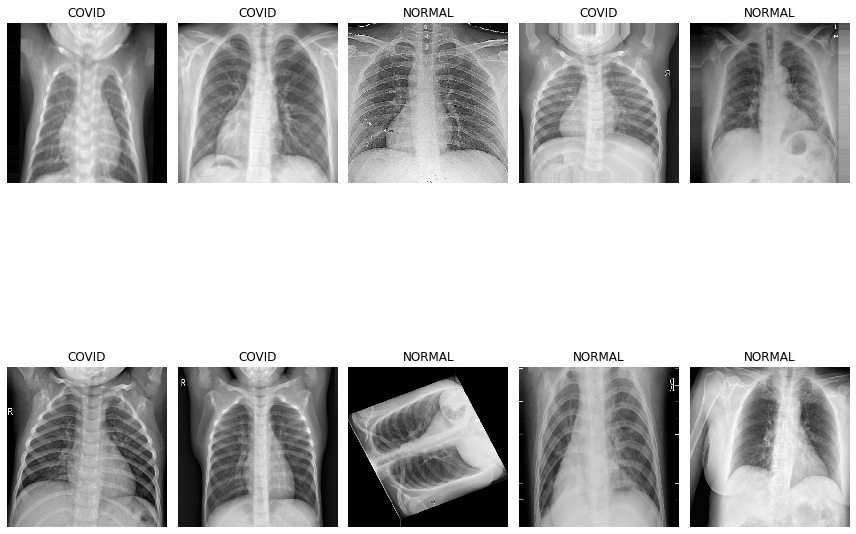

In [6]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'COVID'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()


## Implementing CNN Model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [18]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [19]:
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 498, 498, 64)      640       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 249, 249, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 247, 247, 64)      36928     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 123, 123, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 121, 121, 32)      18464     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 60, 60, 32)      

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [21]:
early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [22]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(train.classes), y=train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 0.9984025559105432, 1: 1.001602564102564}


In [23]:
cnn.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
313/313 [==============================] - 1316s 4s/step - loss: 0.5808 - accuracy: 0.6854 - val_loss: 0.4429 - val_accuracy: 0.7808 - lr: 0.0010
Epoch 2/25
313/313 [==============================] - 1296s 4s/step - loss: 0.4462 - accuracy: 0.7926 - val_loss: 0.3691 - val_accuracy: 0.8378 - lr: 0.0010
Epoch 3/25
313/313 [==============================] - 1351s 4s/step - loss: 0.3969 - accuracy: 0.8290 - val_loss: 0.3492 - val_accuracy: 0.8689 - lr: 0.0010
Epoch 4/25
313/313 [==============================] - 1457s 5s/step - loss: 0.3586 - accuracy: 0.8438 - val_loss: 0.3216 - val_accuracy: 0.8659 - lr: 0.0010
Epoch 5/25
313/313 [==============================] - 1462s 5s/step - loss: 0.3423 - accuracy: 0.8530 - val_loss: 0.3015 - val_accuracy: 0.8679 - lr: 0.0010
Epoch 6/25
313/313 [==============================] - 1518s 5s/step - loss: 0.3220 - accuracy: 0.8648 - val_loss: 0.2572 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 7/25
313/313 [==============================] - 1458

## Save The Model

In [24]:
import joblib
joblib.dump(cnn, 'CNN_1_Best_Scratch.pkl')    # Save the model as a pickle in a file

INFO:tensorflow:Assets written to: ram://a98c6e44-fc73-4f64-a13a-cf558bb7d00c/assets


['scratch_cnn.pkl']